<a href="https://www.kaggle.com/code/giolendius/bias-in-wages?scriptVersionId=184227205" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-size:60px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center; text-decoration-line: underline;"> Biases in Job Wages </h1>

Are there any biases in job wages? Is discrimination present, for example, gender or race discrimination?
We will try to answer the question by inspecting a Kaggle Dataset

Notebook is structured as follows:

* [**Loading the dataset and first observations**](#loading)
* [**Cleaning of the dataset**](#cleaning)
* [**Strategies to handle feature "JobTitle"**](#jobtitle)
* [**Graphs**](#graph)
* [**Analysis**](#analysis)

For data visualization, please visit <h2 style="color:#a3190a; background:#ffffcc"><center>
    [WorldWages](https://dashapiapp.onrender.com/)</center></h2>

<h1 style="font-size:40px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center;"> Loading and first observations </h1>


We start by loading the database and quickly inspect it.
We opt for a more concise name for columns
<a id="loading"></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
db_orig= pd.read_csv("/kaggle/input/ask-a-manager-salary-survey-2021/2302023 Raw Data - Ask A Manager Salary Survey 2021.csv")
print("Shape of the database is ",db_orig.shape)
orig_col_names=list(db_orig.columns)
db_orig.columns = [ 'Timestamp', 'Age', 'Industry', 'JobTitle', 'JobTitle2', "Salary", 'Bonuses', 'Currency', 'Currency: Other', 'SalaryAdditionalContext', 'Country', "USstate", 'City', 'WorkExpT', 'WorkExpSpec', 'Education', 'Gender', 'Race']
db=db_orig.copy()
db.head()

Shape of the database is  (27940, 18)


,Timestamp,Age,Industry,JobTitle,JobTitle2,Salary,Bonuses,Currency,Currency: Other,SalaryAdditionalContext,Country,USstate,City,WorkExpT,WorkExpSpec,Education,Gender,Race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


[voglio provare](#section-uno)


In [3]:
pd.concat([db_orig.isna().sum(), db_orig.nunique(), db_orig.loc[0,:].apply(lambda x: type(x))], axis=1, keys=["Total NaN","#UniqueValues", "Type of entries"])

,Total NaN,#UniqueValues,Type of entries
Timestamp,0,25158,<class 'str'>
Age,0,7,<class 'str'>
Industry,72,1209,<class 'str'>
JobTitle,0,14288,<class 'str'>
JobTitle2,20708,6971,<class 'float'>
Salary,0,4284,<class 'str'>
Bonuses,7253,843,<class 'numpy.float64'>
Currency,0,11,<class 'str'>
Currency: Other,27745,113,<class 'float'>
SalaryAdditionalContext,24907,2970,<class 'float'>


After checking which columns present NaN values, and how many unique values are present in the various features, we make the decisions:
* We remove column Timestamp
* Salary: needs to be converted to type string. After that, we can remove erroneous entry, like 0 and extremely small values
* Age, Work Experience(s): they seems fine, but we can convert them with integers choosing a placeholder
* Currency, Other Cur: Currency is ok, and only when Other is selected we'll clean and merge "Currency: Other" 
* Education and Gender are ok
* Race: a lot of combination are possible, so we will reduce to a single "Race" with "White" having lowest priority

* Country features needs to be cleaned: for examples for "US" are present different (mispelled) instances like "us","U.S", "United Sttes"..

* Job Title (1&2): This is an intersting problem and needs to be taken care of

<a id="cleaning"></a>
<h1 style="font-size:40px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center;"> Cleaning </h1>

We create a function to clean and merge different instances. 

In [4]:
if "Timestamp" in db:
    db.pop("Timestamp")
db.loc[db.duplicated()]
db.drop_duplicates(inplace=True)

In [5]:
def clean_feature(feature, wrong_notation_list, merged_string, EXACT=False):
    """Clean the given features in the database: all the items which contains any element in <<samples_to_be_merge>> are going to be replaced by <merged_string> """
    elements=list(db[feature].dropna().unique())
    if not EXACT:
        synonims = [el for el in elements if any(wrong_notat in el.lower() for wrong_notat in wrong_notation_list )]
    if EXACT:
        synonims = wrong_notation_list
    db.loc[db[feature].isin(synonims),feature] = merged_string
    return f"Cleaning for {merged_string} Completed. Remaining elements present in the feature:",sorted([b for b in elements if b not in synonims])

## Cleaning Country

We first remove ending space from names and capitalize them all.
We run the function multiple times and print the list of all different values of that features in order to clean it further. If we encounter some error like "Currently finance", "california", "International" "promoted" we can retrieve the information of the actual country from USA State or currency typing:

db[db["Country"].str.contains("MISTAKE", case=False)]

db[db["Country"]=="MISTAKE"]

In [6]:
db["Country"]=db["Country"].str.strip().str.capitalize()
clean_feature("Country",["austria"],"Austria")
clean_feature("Country",["australi"],"Australia")
clean_feature("Country",["state", "u.s", "🇺🇸", "Sttes","u. s","i.s.", "sttes","isa","withheld","usa", "supervisor","united y","worldwide","hartford", "america", "currently finance","stat","stare", "sate", "california", "san francisco", "contracts","meet quota","quarterly","promoted", "international"],"USA")
clean_feature("Country",["Us","Ua","Is", "U.a.", "Us", "Us of a", "Y", "The us", "Usd", "Uxz", "Uss", "Na"],"USA", True)
clean_feature("Country",["kingdom","kindom", "uk", "u.k","englan","scotland", "britain","northern","wales"],"UK")
clean_feature("Country",["canad","canda", "csnada", "can", "deducted", "global"],"Canada")
clean_feature("Country",["nether", "nederland", "Netherland"],"Netherlands")
clean_feature("Country",["Nl"],"Netherlands", True)
clean_feature("Country",["finland"],"Finland")
clean_feature("Country",["zeala", "nz"],"NewZealand")
clean_feature("Country",["argentina"],"Argentina")
clean_feature("Country",["italy"],"Italy")
clean_feature("Country",["brasil", "brazil"],"Brazil")
clean_feature("Country",["banglades"],"Bangladesh")
clean_feature("Country",["mexico","méxico"],"Mexico")
clean_feature("Country",["spain","catalonia"],"Spain")
clean_feature("Country",["france"],"France")
clean_feature("Country",["germany"],"Germany")
clean_feature("Country",["kong", "konh"],"HKG")
clean_feature("Country",["ireland"],"Ireland")
clean_feature("Country",["czech", "europe"],"CzechRepublic")
clean_feature("Country",["luxemb"],"Luxembourg")
clean_feature("Country",["china"],"China")
clean_feature("Country",["denmark", "danmark"],"Denmark")
clean_feature("Country",["japan"],"Japan")
clean_feature("Country",["romania"],"Romania")
clean_feature("Country",["malaysia"],"Malaysia")
clean_feature("Country",["uae","united arab emirates"],"UnitedArabEmirates")
clean_feature("Country",["africa"],"SouthAfrica")
clean_feature("Country",["south korea", "southkorea"],"SouthKorea")
clean_feature("Country",["sri lanka"],"SriLanka")
clean_feature("Country",["puerto rico"],"PuertoRico")
if 17755 in db.index:    db.drop(17755,inplace=True) # not possible to understand which country in Europe it is

In [7]:
#db[db["Country"].str.contains("pakistan", case=False)]
#db[db["Country"]=="Na"]

We create a column with the ISO3 country code, using a simple dictionary.
Expand next cell to see it

In [8]:
country_to_iso3 = {
    "Afghanistan": "AFG",
    "Albania": "ALB",
    "Algeria": "DZA",
    "Andorra": "AND",
    "Angola": "AGO",
    "Antigua and Barbuda": "ATG",
    "Argentina": "ARG",
    "Armenia": "ARM",
    "Australia": "AUS",
    "Austria": "AUT",
    "Azerbaijan": "AZE",
    "Bahamas": "BHS",
    "Bahrain": "BHR",
    "Bangladesh": "BGD",
    "Barbados": "BRB",
    "Belarus": "BLR",
    "Belgium": "BEL",
    "Belize": "BLZ",
    "Benin": "BEN",
    "Bhutan": "BTN",
    "Bolivia": "BOL",
    "Bosnia and herzegovina": "BIH",
    "Botswana": "BWA",
    "Brazil": "BRA",
    "Brunei Darussalam": "BRN",
    "Bulgaria": "BGR",
    "Burkina Faso": "BFA",
    "Burundi": "BDI",
    "Bermuda": "BMU",
    "Cabo Verde": "CPV",
    "Cambodia": "KHM",
    "Cameroon": "CMR",
    "Canada": "CAN",
    "Central African Republic": "CAF",
    "Chad": "TCD",
    "Chile": "CHL",
    "China": "CHN",
    "Colombia": "COL",
    "Comoros": "COM",
    "Congo (Congo-Brazzaville)": "COG",
    "Costa Rica": "CRI",
    "Croatia": "HRV",
    "Cuba": "CUB",
    "Cyprus": "CYP",
    "CzechRepublic": "CZE",
    "Democratic Republic of the Congo": "COD",
    "Denmark": "DNK",
    "Djibouti": "DJI",
    "Dominica": "DMA",
    "Dominican Republic": "DOM",
    "Ecuador": "ECU",
    "Egypt": "EGY",
    "El Salvador": "SLV",
    "Equatorial Guinea": "GNQ",
    "Eritrea": "ERI",
    "Estonia": "EST",
    "Ethiopia": "ETH",
    "Fiji": "FJI",
    "Finland": "FIN",
    "France": "FRA",
    "Gabon": "GAB",
    "Gambia": "GMB",
    "Georgia": "GEO",
    "Germany": "DEU",
    "Ghana": "GHA",
    "Greece": "GRC",
    "Grenada": "GRD",
    "Guatemala": "GTM",
    "Guinea": "GIN",
    "Guinea-Bissau": "GNB",
    "Guyana": "GUY",
    "Haiti": "HTI",
    "HKG": "HKG",
    "Honduras": "HND",
    "Hungary": "HUN",
    "Iceland": "ISL",
    "India": "IND",
    "Indonesia": "IDN",
    "Iran": "IRN",
    "Iraq": "IRQ",
    "Ireland": "IRL",
    "Israel": "ISR",
    "Italy": "ITA",
    "Jamaica": "JAM",
    "Japan": "JPN",
    "Jordan": "JOR",
    "Kazakhstan": "KAZ",
    "Kenya": "KEN",
    "Kiribati": "KIR",
    "Kuwait": "KWT",
    "Kyrgyzstan": "KGZ",
    "Laos": "LAO",
    "Latvia": "LVA",
    "Lebanon": "LBN",
    "Lesotho": "LSO",
    "Liberia": "LBR",
    "Libya": "LBY",
    "Liechtenstein": "LIE",
    "Lithuania": "LTU",
    "Luxembourg": "LUX",
    "Madagascar": "MDG",
    "Malawi": "MWI",
    "Malaysia": "MYS",
    "Maldives": "MDV",
    "Mali": "MLI",
    "Malta": "MLT",
    "Marshall Islands": "MHL",
    "Mauritania": "MRT",
    "Mauritius": "MUS",
    "Mexico": "MEX",
    "Micronesia": "FSM",
    "Moldova": "MDA",
    "Monaco": "MCO",
    "Mongolia": "MNG",
    "Montenegro": "MNE",
    "Morocco": "MAR",
    "Mozambique": "MOZ",
    "Myanmar (formerly Burma)": "MMR",
    "Namibia": "NAM",
    "Nauru": "NRU",
    "Nepal": "NPL",
    "Netherlands": "NLD",
    "NewZealand": "NZL",
    "Nicaragua": "NIC",
    "Niger": "NER",
    "Nigeria": "NGA",
    "North Korea": "PRK",
    "North Macedonia": "MKD",
    "Norway": "NOR",
    "Oman": "OMN",
    "Pakistan": "PAK",
    "Palau": "PLW",
    "Palestine State": "PSE",
    "Panama": "PAN",
    "Papua New Guinea": "PNG",
    "Paraguay": "PRY",
    "Peru": "PER",
    "Philippines": "PHL",
    "Poland": "POL",
    "Portugal": "PRT",
    "PuertoRico":"PRG",
    "Qatar": "QAT",
    "Romania": "ROU",
    "Russia": "RUS",
    "Rwanda": "RWA",
    "Saint Kitts and Nevis": "KNA",
    "Saint Lucia": "LCA",
    "Saint Vincent and the Grenadines": "VCT",
    "Samoa": "WSM",
    "San Marino": "SMR",
    "Sao Tome and Principe": "STP",
    "Saudi Arabia": "SAU",
    "Senegal": "SEN",
    "Serbia": "SRB",
    "Seychelles": "SYC",
    "Sierra Leone": "SLE",
    "Singapore": "SGP",
    "Slovakia": "SVK",
    "Slovenia": "SVN",
    "Solomon Islands": "SLB",
    "Somalia": "SOM",
    "SouthAfrica": "ZAF",
    "SouthKorea": "KOR",
    "SouthSudan": "SSD",
    "Spain": "ESP",
    "SriLanka": "LKA",
    "Sudan": "SDN",
    "Suriname": "SUR",
    "Sweden": "SWE",
    "Switzerland": "CHE",
    "Syria": "SYR",
    "Tajikistan": "TJK",
    "Tanzania": "TZA",
    "Thailand": "THA",
    "Timor-Leste": "TLS",
    "Togo": "TGO",
    "Tonga": "TON",
    "Trinidad and tobago": "TTO",
    "Tunisia": "TUN",
    "Turkey": "TUR",
    "Turkmenistan": "TKM",
    "Tuvalu": "TUV",
    "Uganda": "UGA",
    "Ukraine": "UKR",
    "UnitedArabEmirates": "ARE",
    "UK": "GBR",
    "USA": "USA",
    "Uruguay": "URY",
    "Uzbekistan": "UZB",
    "Vanuatu": "VUT",
    "Venezuela": "VEN",
    "Vietnam": "VNM",
    "Yemen": "YEM",
    "Zambia": "ZMB",
    "Zimbabwe": "ZWE"
}


In [9]:
db["CountryCode"]=db["Country"].map(country_to_iso3)

In [10]:
bef= len(db)
db=db.groupby("Country").filter(lambda x: len(x)>19)
print(f"Removed entries for scarse-represented countries.\nFrom {bef} entries to {len(db)}")

Removed entries for scarse-represented countries.
From 27790 entries to 27457


## Cleaning of gender

Gender
Woman                            21012
Man                               5263
Non-binary                         733
Other or prefer not to answer      283
Prefer not to answer                 1
Name: count, dtype: int64


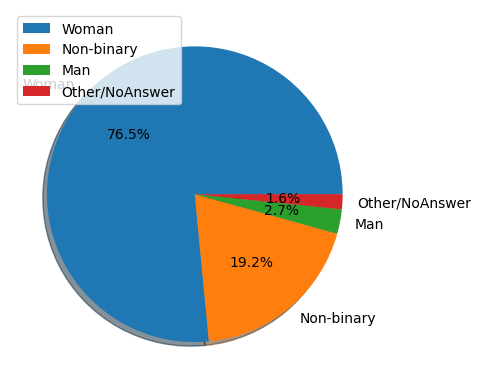

In [11]:
print(db["Gender"].value_counts())
db.replace(["Other or prefer not to answer","Prefer not to answer"], "Other/NoAnswer", inplace=True)
db["Gender"]=db["Gender"].fillna("Other/NoAnswer")
plt.pie(db["Gender"].value_counts(), labels=db["Gender"].unique(), shadow=True, autopct="%1.0001f%%")
plt.legend(loc="upper left")
plt.show()

## Cleaning of Race

In [12]:
db["Race"]=db["Race"].fillna("NoAnswer")
clean_feature("Race",["black"],"Black")
clean_feature("Race",["hispanic"],"Hispanic")
clean_feature("Race",["native"],"NativeAmerican")
clean_feature("Race",["middle"],"MiddleEastern")
clean_feature("Race",["asian"],"Asian")
clean_feature("Race",["other"],"NoAnswer")
db["Race"].value_counts()

Race
White             22854
Asian              1672
Hispanic           1001
Black               842
NoAnswer            816
MiddleEastern       154
NativeAmerican      118
Name: count, dtype: int64

## Cleaning of Salary

We convert to int type and remove commas

We then remove entries with salary =0 or less than 10k, which are not realistic as yearly income

In [13]:
db["Salary"]=pd.to_numeric(db["Salary"].str.replace(",",""))

In [14]:
db= db[db.Salary>10000]#.sort_values("Salary")

## Cleaning of WorkExp

Replace string of ranges with some integer value (middle value)

In [15]:
pd.set_option('future.no_silent_downcasting', True)#does not show a future wrning
db.replace({'5-7 years':6, '8 - 10 years':9, '2 - 4 years':3, '21 - 30 years':25,
       '11 - 20 years':15, '1 year or less':1, '41 years or more':45,
       '31 - 40 years':35}).infer_objects(copy=False)
print( )

## Clean Currency 

Step 1: Inspect and clean Currency: Other, then merge it into Currency
Step 2: Create a Salary: USD column with the conversion rate

In [16]:
#see what needs to be cleaned

db[db["Currency"]=="Other"]["Currency: Other"].value_counts()

Currency: Other
USD                    8
DKK                    7
AUD                    3
NZD                    2
Dkk                    2
GBP                    2
Australian Dollars     1
dkk                    1
CAD                    1
Danish Kroner          1
Equity                 1
CHF                    1
AUD Australian         1
DKK                    1
US Dollar              1
American Dollars       1
SEK                    1
Euro                   1
Name: count, dtype: int64

In [17]:
#clean
db["Currency: Other"]=db["Currency: Other"].str.strip().str.upper()
clean_feature("Currency: Other",["us dollar","american dollars", "other/noanswer", "equity"], "USD")
clean_feature("Currency: Other",["aud australian","australian dollars"], "AUD")
clean_feature("Currency: Other",["danish kroner"], "DKK")
clean_feature("Currency: Other",["eur"], "EUR")

#Inserting them into Currency, and popping the column
db.loc[db["Currency"]=="Other", "Currency"] = db["Currency: Other"]
db.pop("Currency: Other")

print("Currency and Currency:Other are cleaned")
print("For some reason, the creators of databses unified AUD and NZD, which, as many people pointed out inside this database, they are quite different currencies. I would differentiate them in a more precise analysis.")
db["Currency"].value_counts()

Currency and Currency:Other are cleaned
For some reason, the creators of databses unified AUD and NZD, which, as many people pointed out inside this database, they are quite different currencies. I would differentiate them in a more precise analysis.


Currency
USD        22977
CAD         1652
GBP         1565
EUR          531
AUD/NZD      495
SEK           38
CHF           35
JPY           23
DKK           12
AUD            5
NZD            2
Name: count, dtype: int64

In [18]:
usd_to_currency = {
    "USD": 1,
    'CAD': 1.25,   # Canadian Dollar
    'GBP': 0.72,   # British Pound
    'EUR': 0.84,   # Euro
    'AUD/NZD': 1.35, # Australian Dollar / New Zealand Dollar
    "AUD": 1.35,
    "NZD": 0.61,
    'SEK': 8.58,   # Swedish Krona
    'CHF': 0.91,   # Swiss Franc
    'JPY': 110.53, # Japanese Yen
    "DKK": 6.88
}

def conversion(row):
    if row["Currency"] in usd_to_currency:
        return round(row["Salary"]/ (usd_to_currency.get(row["Currency"])))
    else:
        return None

db["USD_Equiv_Salary"] = db.apply(lambda x : conversion(x), axis=1)

## **Final Cleaning: Outliers**

We remove unnecesary columns, and we remove outliers

In [19]:
db.pop("City")

0               Boston
1            Cambridge
2          Chattanooga
3            Milwaukee
4           Greenville
             ...      
27934          bristol
27936       Cincinnati
27937           Ithaca
27938            århus
27939    New York City
Name: City, Length: 27337, dtype: object

In [20]:
remove_outliers_fromDB = True
def remove_outliers(country):
    dff=db[db["Country"]==country]
    in_len=len(dff)
    Q1 = dff['USD_Equiv_Salary'].quantile(0.25)
    Q3 = dff['USD_Equiv_Salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dff[(dff['USD_Equiv_Salary'] < lower_bound) | (dff['USD_Equiv_Salary'] > upper_bound)].index
    db.drop(outliers, inplace=True)
    return len(outliers), in_len

In [21]:
if remove_outliers_fromDB:
    tot=0
    for country in db["Country"].unique():
        lost, initial =remove_outliers(country)
        tot+=lost
        print(f"{country} lost {lost} entries out of the {initial} initial entries, approx {round(lost/initial,3)*100}%")
    remove_outliers_fromDB= False
    print(f"\nRemoved {tot} outliers!")

USA lost 929 entries out of the 22909 initial entries, approx 4.1000000000000005%
UK lost 85 entries out of the 1578 initial entries, approx 5.4%
Canada lost 63 entries out of the 1668 initial entries, approx 3.8%
Netherlands lost 3 entries out of the 86 initial entries, approx 3.5000000000000004%
Australia lost 16 entries out of the 385 initial entries, approx 4.2%
Spain lost 3 entries out of the 44 initial entries, approx 6.800000000000001%
France lost 3 entries out of the 64 initial entries, approx 4.7%
Germany lost 8 entries out of the 185 initial entries, approx 4.3%
Ireland lost 5 entries out of the 123 initial entries, approx 4.1000000000000005%
Denmark lost 3 entries out of the 24 initial entries, approx 12.5%
Switzerland lost 3 entries out of the 37 initial entries, approx 8.1%
Belgium lost 3 entries out of the 34 initial entries, approx 8.799999999999999%
Sweden lost 1 entries out of the 41 initial entries, approx 2.4%
Japan lost 3 entries out of the 30 initial entries, appro

<a id="jobtitle"></a>
<h1 style="font-size:40px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center;"> Categorizing JobTitles </h1>

We'll start by merging JobTitle 1 and 2 where this is not NaN

In [22]:
#create db and merge Titl 1 and 2
JtV=pd.DataFrame(db[["JobTitle", "JobTitle2"]])
JtV.loc[JtV["JobTitle2"].notnull(), ["JobTitle"]]=JtV["JobTitle"]+"   "+JtV["JobTitle2"].astype(str)
JtV.pop("JobTitle2")
db["JobTitle"]=JtV["JobTitle"]

## Try: Use Word2Vec

In [23]:
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from string import punctuation 
from sklearn.cluster import KMeans

In [24]:
english=stopwords.words("english")
english.remove("it")
def tokenize(title):
    #remove punct and lower
    title = ''.join([char for char in title if char not in punctuation]).lower()
    #tokenize
    title = re.findall('\w+',title)
    return [word for word in title if word not in english]

JtV["Tokens"]= JtV["JobTitle"].apply(tokenize)

In [25]:
#Dropping a line with empty "JobTitle"
empty=JtV[JtV["Tokens"].apply(len)==0].index
db.drop(empty, inplace=True)
JtV.drop(empty, inplace=True)

In [26]:
# Training of Word2Vec
vector_size=100
model = Word2Vec(JtV["Tokens"].tolist(), vector_size=vector_size, window=5, workers=4)

In [27]:
def title_to_vect(row):
    vector_sum=np.zeros(vector_size)
    for word in row:
        if word in model.wv:
            vector_sum += model.wv[word]
    return vector_sum/len(row)

JtV["JtV"] = JtV['Tokens'].apply(title_to_vect)

In [28]:
kmeans = KMeans(n_clusters=10, n_init=10)
kmeans.fit(np.stack(JtV["JtV"]))

# Assigning categories
JtV['JTCategory'] = kmeans.labels_

In [29]:
for work in ["librarian", "manager", "doctor","ceo","engineer"]:
    print(work, "was assigned to categories",list(JtV.loc[JtV["JobTitle"].str.contains(work, case=False),"JTCategory"].unique()))

librarian was assigned to categories [0, 9, 6, 7, 2, 8, 3, 5, 1]
manager was assigned to categories [1, 2, 7, 9, 0, 3, 8, 6, 5]
doctor was assigned to categories [5, 9, 0, 2]
ceo was assigned to categories [0, 8, 9, 5, 2, 1]
engineer was assigned to categories [4, 7, 3, 2, 9, 0, 1, 8]


**Conclusion**

As one can see from the previous cell, this procedure does not provide a consistent categorization: some job title keyword are spread across categories.

If time allows I would like to improve this method, but for the time beeing I will proceed with a more empiric algorithm.

Future improvement might include the following idea:
for each JobTitle we used the sum of all word-vectors. We might want to change this, since this does put similar weights on all keyword.
For example, we might try to use, for each title, only the word-vector most present in the entire dataset... Or maybe a linear combination of word-vectors with higher coefficient for more common vectors

## Dictionary from most common words 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

if "JobTitle2" in db:
    db["JobTitle2"]=np.nan
    db.rename(columns={'JobTitle2': 'JCat'}, inplace=True)

def most_common(datab, top=10):
    """Function to find most commons keywords in JobTitle"""
    count_vect = CountVectorizer(analyzer = tokenize)
    key_titles= count_vect.fit_transform(datab).sum(axis= 0)
    #pd.DataFrame(data = key_titles, columns = count_vect.get_feature_names_out())
    #prova.sum()
    key_titles=pd.DataFrame({"Word":count_vect.get_feature_names_out(),"#":np.squeeze(np.asarray(key_titles))})
    return key_titles.sort_values("#", ascending=False)[:top]

def cont(keyword):
    """return entries of db where [JobTitle] contains keyword"""
    return db.loc[db["JobTitle"].str.contains(keyword, case=False),["JobTitle", "USD_Equiv_Salary","Country","JCat"]]

def assign_to_cat(keyword,category=None):
    """all empty JCat whoose JobTitle contains keyword are assigned to category"""
    
    if not category:
        category=keyword.capitalize()
    db.loc[(db["JCat"].isna())&(db["JobTitle"].str.contains(keyword, case=False)),"JCat"]=category

In [31]:
db["Country"].value_counts()

Country
USA            21979
Canada          1605
UK              1493
Australia        369
Germany          177
NewZealand       123
Ireland          118
Netherlands       83
France            61
Spain             41
Sweden            40
Switzerland       34
Belgium           31
Japan             27
Denmark           21
Name: count, dtype: int64

In [32]:
most_common(JtV.loc[db["JCat"].isna(),'JobTitle'])

,Word,#
3789,manager,5533
5653,senior,2833
1998,director,2456
2284,engineer,2111
634,assistant,1817
446,analyst,1727
5813,software,1318
662,associate,1234
5859,specialist,1216
1573,coordinator,1111


In [33]:
a=cont("counsel").sort_values("USD_Equiv_Salary", ascending=False)[:251]
a[a["JCat"].isna()]

,JobTitle,USD_Equiv_Salary,Country,JCat
23043,Deputy General Counsel,194000.0,USA,NaN
11677,Lead Corporate Counsel In house employment l...,191513.0,USA,NaN
14381,Counsel In-House Counsel for Manufacturing c...,191000.0,USA,NaN
8818,Chief Privacy Officer/Counsel,190000.0,USA,NaN
14869,Senior counsel,190000.0,USA,NaN
...,...,...,...,...
24460,Mental Health Counselor LPC at counseling ce...,36000.0,USA,NaN
27346,Financial Aid Counselor,34000.0,USA,NaN
9137,School-Based Intervention Counselor,33280.0,USA,NaN
13363,Social worker Social worker/counselor to ref...,28571.0,France,NaN


In [34]:
for el in["manager","coordinator", "associate", "advisor", "planner", "assistant"]:
    assign_to_cat(el,"Manager")
for el in ["executive", "president","chief"]:
    assign_to_cat(el,"Executive")
for el in ["director","dean", "head"]:
    assign_to_cat(el, "Director")
for el in ["senior","lead", "prof", "supervisor", "counsel"]:
    assign_to_cat(el,"Senior Professionals")
for el in ["data","scienti" , "research","writer","analyst","consultant","engineer", "nurse","developer",
           "attorney","legal","accountant","software","specialist", "designer", "editor", "librarian", "teacher"]:
    assign_to_cat(el,"Specialists")
for el in ["security", "administrat", "consultant", "hr","human","support", "technician", "installer","sales", "social"]:
    assign_to_cat(el,"Service Workers")

/tmp/ipykernel_74/22044949.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Manager' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  db.loc[(db["JCat"].isna())&(db["JobTitle"].str.contains(keyword, case=False)),"JCat"]=category


In [35]:
db=db.drop(["Salary","Currency","SalaryAdditionalContext", "Industry","Bonuses","WorkExpSpec"], axis=1)
db.to_csv("/kaggle/working/JobWages.csv")

<a id="graph"></a>
<h1 style="font-size:40px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center;"> Graphs and visualization</h1>

For data visualization, please visit [WorldWages](https://dashapiapp.onrender.com/).

*The website might take a bit to load (even up to 90 seconds, sorry), please be patient. Also, we suggest to open the website on notebooks and not on mobiles*

<a id="analysis"></a>
<h1 style="font-size:40px; border-radius:25px;
           background:#d4f8ff; color:#a3190a; text-align:center;">Analysis </h1> 

We use ANOVA to show presence/absence of some biases. 
The results here obtained are already availlable on *https://dashapiapp.onrender.com/*[](http://)

In [36]:
def Anova(country, two_genders):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    dbA=db.loc[db["Country"]==country,["Gender", "USD_Equiv_Salary", "JCat"]]
    dbA=dbA.loc[dbA["Gender"].isin(two_genders),:]
    model = ols('USD_Equiv_Salary ~ C(Gender)+C(JCat)+C(JCat):C(Gender)', data=dbA).fit()
    result=sm.stats.anova_lm(model, typ=1)["PR(>F)"]["C(Gender)"]
    
    if result<0.05:
        print(f"There is evidence that the salary levels of two genders: \n   {two_genders[0]}  and   {two_genders[1]}  in {country}\nhave different means!\np-value:{result}\n")
    else:
        print(f"{country},{two_genders}: Not enough evidence to show biases")
        print("p-value",result, "\n\n")
    return result

In [37]:
an_res = {}
for country in ["USA", "Canada", "UK"]:
    an_res[country] = {}
    for pair in [("Man","Woman"),("Man","Non-binary"),("Non-binary","Woman")]:
        an_res[country][pair]=Anova(country,pair)

There is evidence that the salary levels of two genders: 
   Man  and   Woman  in USA
have different means!
p-value:5.576257069503817e-188

There is evidence that the salary levels of two genders: 
   Man  and   Non-binary  in USA
have different means!
p-value:1.4786629583514827e-57

There is evidence that the salary levels of two genders: 
   Non-binary  and   Woman  in USA
have different means!
p-value:4.40058639784855e-13

There is evidence that the salary levels of two genders: 
   Man  and   Woman  in Canada
have different means!
p-value:4.0246264902531004e-15

There is evidence that the salary levels of two genders: 
   Man  and   Non-binary  in Canada
have different means!
p-value:1.3176457636311075e-05

Canada,('Non-binary', 'Woman'): Not enough evidence to show biases
p-value 0.05885702325999396 


There is evidence that the salary levels of two genders: 
   Man  and   Woman  in UK
have different means!
p-value:3.227814267104466e-21

There is evidence that the salary levels of